# Mie Scattering Tutorial 

Please make sure that 

1) The refractive_indices folder is in the input/refractive_indices folder and 
2) The aerosol_database.hdf5 is in the input folder

This tutorial will cover all the utilities of Mie Scattering

# Normal Poseidon Inputs

Just for simplicity, we define a hot jupiter composed of only H and He in order to display the effects of Mie Scattering

In [1]:
from POSEIDON.clouds_make_database import make_aerosol_database

make_aerosol_database()

---------------------
Loading in .npy files from
/home/ryanmacdonald/code/POSEIDON/inputs/opacity/refractive_indices/
---------------------
---------------------
Generating database from the following aerosols
---------------------
Fe
H2O
MgO
KCl
Mg2SiO4_amorph_sol_gel
NaCl
SiO2
Na2S
Fe2O3
CH4
SiO2_amorph
MgSiO3
Tholin
---------------------
Saving new aerosol database as
/home/ryanmacdonald/code/POSEIDON/inputs/opacity/aerosol_database.hdf5
---------------------


In [2]:
from POSEIDON.core import wl_grid_constant_R
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J

#***** Define stellar properties *****#

R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550            # Stellar effective temperature (K)
Met_s = -0.25          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'Mie_Testing'  # Planet name used for plots, output files etc.

R_p = 1.87*R_J                           # Planetary radius (m)
R_p = 1.722*R_J
M_p = 0.78*M_J
# Formula : a = GM/R^2
g_p = (6.67430e-11*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)
T_eq = 1447

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

CB_color_cycle = ['#0072B2', '#009E73', '#D55E00', '#CC79A7',
                 '#F0E442', '#56B4E9','#56B4E9']


wl_min = 0.2    # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 1000       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

### Option 1 : Aerosol = 'file_read'

This option is reccomended for forward models for quick testing

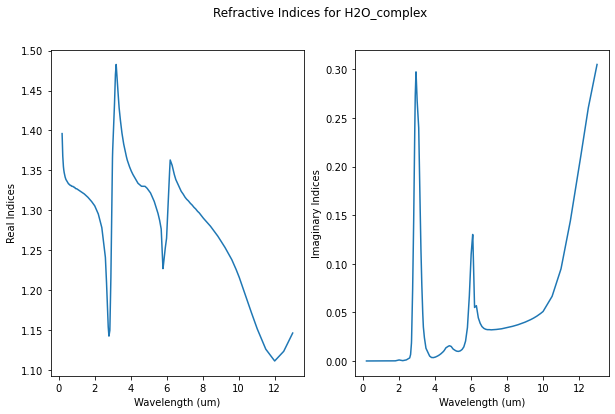

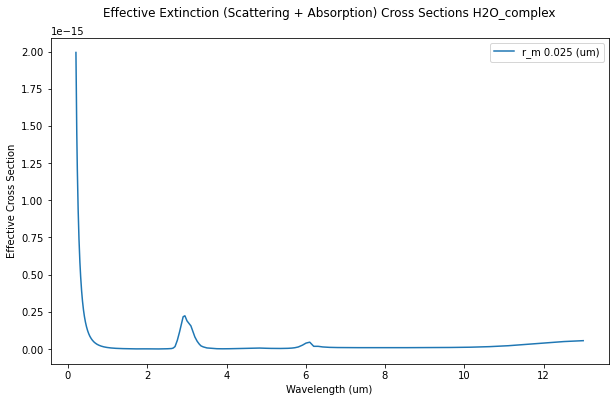

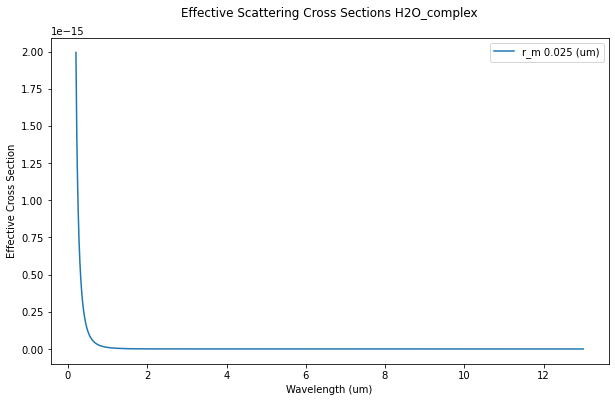

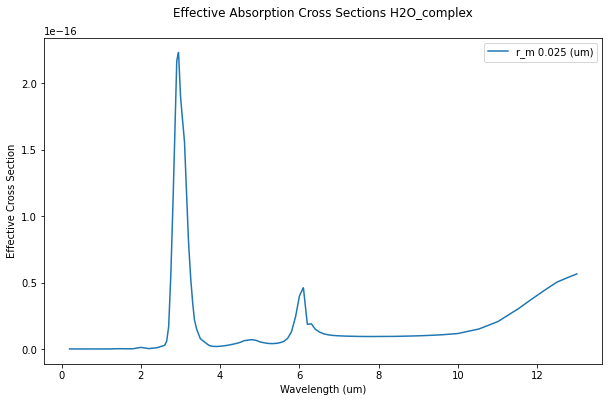

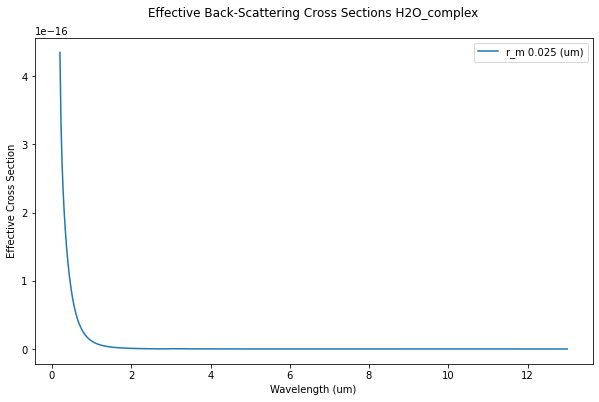

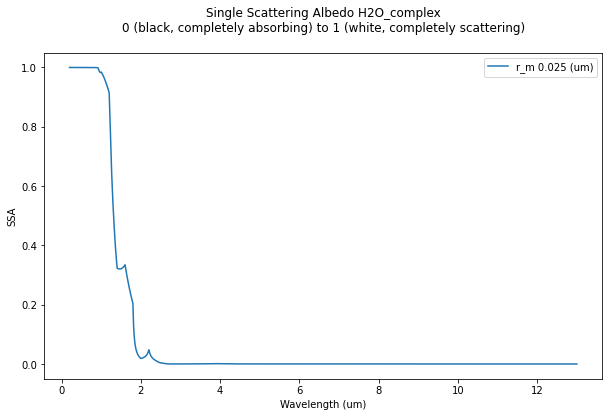

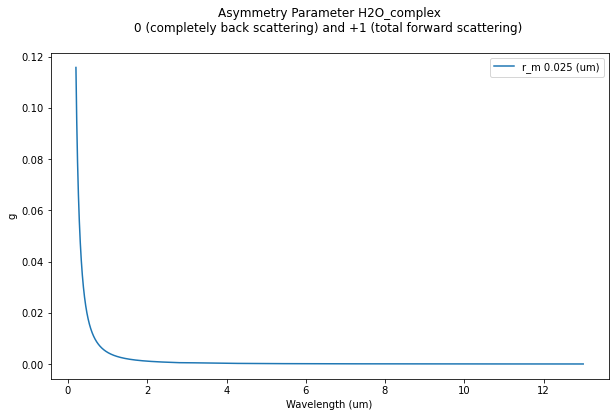

In [3]:
from POSEIDON.clouds_make_database_emission import plot_refractive_indices_from_file, plot_effective_cross_section_from_file
import numpy as np 

# First, lets check how the cross sections that our own file : 'H2O_complex.txt' makes
file_name = './H2O_complex.txt'

# Plotting the refractive indices 
plot_refractive_indices_from_file(wl, file_name)

# Plotting the cross section from LX_MIE 
r_m = 0.025 # mean particle size

plot_effective_cross_section_from_file(wl, r_m, file_name)

In [4]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Uniform_X_File_Read'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = []

aerosol_species = ['file_read']

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print("Free parameters model: " + str(model['param_names']))

Free parameters model: ['R_p_ref' 'T' 'log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']


In [5]:
from POSEIDON.core import make_atmosphere
from POSEIDON.clouds_make_database import load_refractive_indices_from_file
import numpy as np
import matplotlib.pyplot as plt

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p # Radius at reference pressure

# X Params
X_params = np.array([])

# Cloud Params uniform x
log_r_m                 =   -2.0
log_X_Mie               =   -8

# Preload the refractive indices from the file 
file_name = './H2O_complex.txt'
r_i_real, r_i_complex = load_refractive_indices_from_file(wl, file_name)

cloud_params = np.array([log_r_m, log_X_Mie, r_i_real, r_i_complex])

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([1348])              # T (K)

# Generate the atmospheres
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, X_params, cloud_params)

In [6]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

wl_min = 0.2    # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 1000       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Opacity pre-interpolation complete.


In [7]:
from POSEIDON.core import compute_spectrum

# Generate our first transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

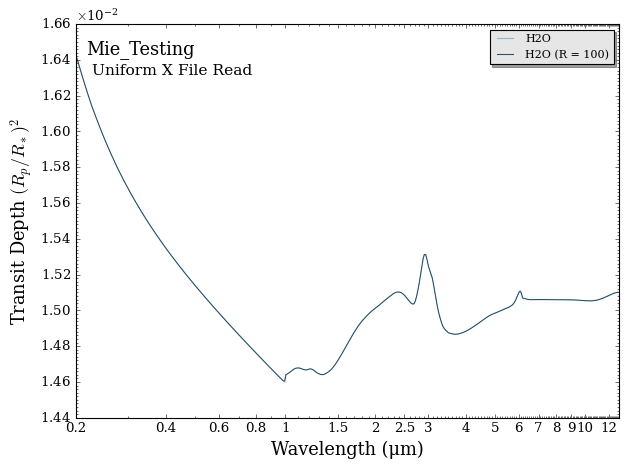

In [8]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

# Produce figure and save to file

fig = plot_spectra(spectra, planet, R_to_bin = 100, 
                   spectra_labels = ['H2O'], 
                   plt_label = 'Uniform X File Read',
                   colour_list=CB_color_cycle[:1]) 

### Option 2 : Directly add an aerosol to the database

This option is reccomended if retrievals will be run using some lab data. 

To add your own lab data to the database for personal use, please refer to clouds_make_database and run 

precompute_cross_sections_one_aerosol(aerosol)

Ensure that the txt file is in input/refractive_indices with the two first lines being a header, the first column being wavelengths (um) spanning at least 0.2 to 30 um, second column being the real indices, and the third column being the imaginary indices. The txt file should be named aerosol + '_complex.txt

This function will load in a txt file at : input_file_path + 'refractive_indices/' + aerosol + '_complex.txt'

Computing the npy array of cross sections should take about a day. However, good news is that you only have to do it once! Now you don't have to wait around for Qext calculations. 

To add this to the database, run make_aerosol_database()

In [10]:
from POSEIDON.clouds_make_database_emission import make_aerosol_database

make_aerosol_database()

---------------------
Loading in .npy files from
/home/ryanmacdonald/code/POSEIDON/inputs/opacity/refractive_indices/
---------------------
---------------------
Generating database from the following aerosols
---------------------
SiO2_amorph
---------------------
Saving new aerosol database as
/home/ryanmacdonald/code/POSEIDON/inputs/opacity/aerosol_database_emission.hdf5
---------------------


Load in the grid to make sure it works

Reading in database for aerosol cross sections...


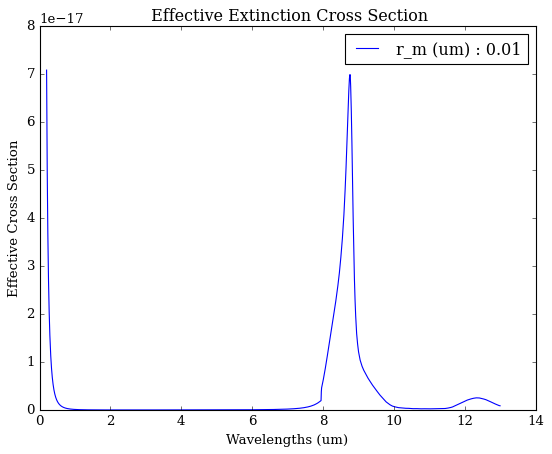

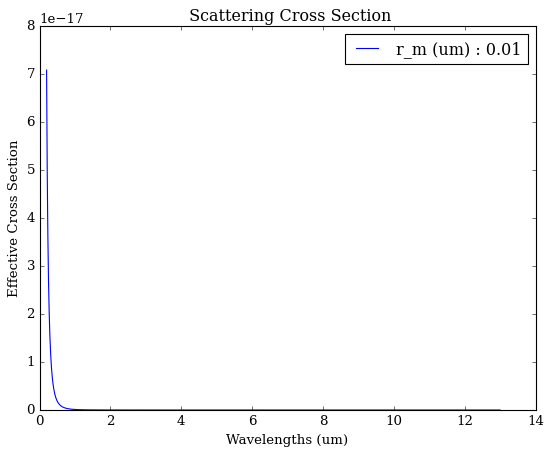

In [11]:
from POSEIDON.clouds_aerosols_emission import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

# Load in the grid with three aerosols
aerosol_grid = load_aerosol_grid(['SiO2_amorph'])

# Test to see if the cross sections come out with SiO2 particle, 0.01 um sized
r_m = 0.01
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], ['SiO2_amorph'],)

label = 'r_m (um) : ' + str(r_m)
title =' Effective Extinction Cross Section'
plt.plot(wl,sigma_Mie_interp_array['SiO2_amorph']['eff_ext'], label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Effective Cross Section')
plt.show()

label = 'r_m (um) : ' + str(r_m)
title =' Scattering Cross Section'
plt.plot(wl,sigma_Mie_interp_array['SiO2_amorph']['eff_scat'], label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Effective Cross Section')
plt.show()